# Yelp API - Lab


## Introduction 

Now that we've seen how the Yelp API works and some basic Folium visualizations, it's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system on to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you, but make the request below.

In [6]:
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [7]:
# Your code here
import requests
import pandas as pd


keys = get_keys("/Users/franc/.secret/YelpFile4.json")

client_id = keys['Client ID']
api_key = keys['API Key']

term = 'pizza'
location = 'New York NY'

url = 'https://api.yelp.com/v3/businesses/search'

headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

url_params = {
                'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
            }
response = requests.get(url, headers=headers, params=url_params) #Your code here
print(response)
print(type(response.text))
print(response.text[:1000])

<Response [200]>
<class 'str'>
{"businesses": [{"id": "HokS8DZ_wy1MSAsm8kxzcA", "alias": "and-pizza-new-york-13", "name": "&pizza", "image_url": "https://s3-media2.fl.yelpcdn.com/bphoto/2A3X7QVksrVMz0I2zAKuXQ/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/and-pizza-new-york-13?adjust_creative=FB0AyqWTKW7t72DHOpzyMA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=FB0AyqWTKW7t72DHOpzyMA", "review_count": 17, "categories": [{"alias": "pizza", "title": "Pizza"}], "rating": 4.5, "coordinates": {"latitude": 40.70579, "longitude": -74.00859}, "transactions": [], "location": {"address1": "63 Wall St", "address2": "", "address3": null, "city": "New York", "zip_code": "10005", "country": "US", "state": "NY", "display_address": ["63 Wall St", "New York, NY 10005"]}, "phone": "", "display_phone": "", "distance": 1202.061602231933}, {"id": "ysqgdbSrezXgVwER2kQWKA", "alias": "julianas-pizza-brooklyn-5", "name": "Juliana's Pizza", "image_url": "https://s3-media1.fl

## Pagination

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [8]:
# Your code here; use a function or loop to retrieve all the results from your original request
print(response.json().keys())


dict_keys(['businesses', 'total', 'region'])


In [9]:
print(response.json()['total'])

10800


In [10]:
import pandas as pd
import time

def yelp_call(url_params, api_key):
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer {}'.format(api_key)}
    response = requests.get(url, headers=headers, params=url_params)
    
    df = pd.DataFrame(response.json()['businesses'])
    return df

def all_results(url_params, api_key):
    num = response.json()['total'] #store the total of records in a variable, in this case: 10800
    print('{} total matches found.'.format(num))
    cur = 0
    dfs = []
    while cur < num and cur < 1000:    
        url_params['offset'] = cur #offset is a parameter from the API to make sure you dont upload the same info twice
        dfs.append(yelp_call(url_params, api_key)) #each yelp call returns a df format downloaded from API Yelp. Store in a list first
        time.sleep(1) #Wait a second
        cur += 50 #select 50 pieces of data extra
    df = pd.concat(dfs, ignore_index=True) #transfer the data to a df from a list
    return df

term = 'pizza'
location = 'Astoria NY'
url_params = {  'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
                'limit' : 50
             }
df = all_results(url_params, api_key)
print(len(df))
df.head()

10800 total matches found.
1000


,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,milkflower-astoria,"[{'alias': 'pizza', 'title': 'Pizza'}]","{'latitude': 40.7628961, 'longitude': -73.9207...",(718) 204-1300,461.294783,1OZPOWZwJr-hpvMt6TD4ug,https://s3-media3.fl.yelpcdn.com/bphoto/SQG1kI...,False,"{'address1': '3412 31st Ave', 'address2': '', ...",Milkflower,+17182041300,$$,4.5,602,[],https://www.yelp.com/biz/milkflower-astoria?ad...
1,rizzos-fine-pizza-astoria,"[{'alias': 'pizza', 'title': 'Pizza'}]","{'latitude': 40.76335, 'longitude': -73.91516}",(718) 721-9862,713.161109,hB2S1y5T9ufMz5ksHHhdIA,https://s3-media3.fl.yelpcdn.com/bphoto/p1IQ1w...,False,"{'address1': '3013 Steinway St', 'address2': '...",Rizzo's Fine Pizza,+17187219862,$,4.0,570,"[delivery, pickup]",https://www.yelp.com/biz/rizzos-fine-pizza-ast...
2,rosas-pizza-astoria,"[{'alias': 'pizza', 'title': 'Pizza'}]","{'latitude': 40.7671877, 'longitude': -73.9299...",(718) 726-1296,655.314626,5Uo_a_Kl53O_yKglSR5nBA,https://s3-media3.fl.yelpcdn.com/bphoto/6VImxk...,False,"{'address1': '31-1 21st St', 'address2': '', '...",Rosa's Pizza,+17187261296,$$,4.5,66,[],https://www.yelp.com/biz/rosas-pizza-astoria?a...
3,basil-brick-oven-pizza-astoria,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...","{'latitude': 40.770946, 'longitude': -73.92001}",(718) 204-1205,487.240449,JjpCF17AxF6RPOyimw21cw,https://s3-media1.fl.yelpcdn.com/bphoto/VLm8YK...,False,"{'address1': '28-17 Astoria Blvd', 'address2':...",Basil Brick Oven Pizza,+17182041205,$$,4.0,472,"[delivery, pickup]",https://www.yelp.com/biz/basil-brick-oven-pizz...
4,napoli-pizza-and-pasta-astoria-4,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...","{'latitude': 40.75718, 'longitude': -73.92686}",(718) 472-1146,1148.015816,Lw58gDv9ipwtOcg2EIJp3w,https://s3-media3.fl.yelpcdn.com/bphoto/os_Qgp...,False,"{'address1': '33-02 35th Ave', 'address2': '',...",Napoli Pizza & Pasta,+17184721146,$,4.0,290,"[delivery, pickup]",https://www.yelp.com/biz/napoli-pizza-and-past...


## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

In [11]:
# Your code here
df.describe()

,distance,rating,review_count
count,1000.000000,1000.00000,1000.000000
mean,3110.902301,3.49850,208.067000
std,1946.527866,0.72717,344.333847
min,45.292764,1.00000,1.000000
25%,2328.231158,3.00000,34.000000
50%,3153.955069,3.50000,108.500000
75%,3996.568805,4.00000,250.500000
max,36047.729347,5.00000,4038.000000


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 12.,  13.,  32.,  82.,   0., 165., 295., 280., 109.,  12.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

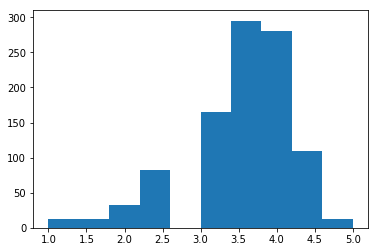

In [16]:
plt.hist(df['rating'])

In [17]:
df.price = df.price.fillna(value=0)
price_dict = {"$": 1, "$$":2, "$$$": 3, "$$$$":4}
df.price = df.price.map(price_dict)


C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([359.,   0.,   0., 465.,   0.,   0.,  53.,   0.,   0.,   9.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

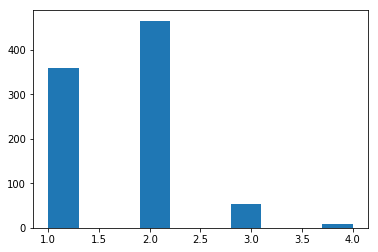

In [19]:
plt.hist(df['price'])

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [21]:
# Your code here
import folium

lat_long = df['coordinates'].iloc[0] #selecting the fist row
lat = lat_long['latitude']
long = lat_long['longitude']
yelp_map = folium.Map([lat, long])

for row in df.index:
    try:
        lat_long = df['coordinates'][row]
        lat = lat_long['latitude']
        long = lat_long['longitude']
        name = df['name'][row]
        rating = df['rating'][row]
        price = df['price'][row]
        details = "{}\nPrice: {} Rating:{}".format(name,str(price),str(rating))
        popup = folium.Popup(details, parse_html=True)
        marker = folium.Marker([lat, long], popup=popup)
        marker.add_to(yelp_map)
    except:
        print('Hit error on row: {}'.format(row))
yelp_map

## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!